# Functions

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def is_there_unk(test_corpus, ref_freq_dict):
  # reference_frequency is a dictionary that contains our vocabulary
  # test_corpus is a testset we want to check whether it has unknown word
  # test_corpus is a list of list of words
  at_least_one_unk =[word for sublist in test_corpus for word in sublist if word not in ref_freq_dict]
  if  at_least_one_unk:
    return True
  return False
def remove_rare(corpus, freq, num, min_sentence_len):
  #corpus is a list of list of rare_tokens
  # freq is the frequency of all trainset words
  remove_ids = []
  for i in range(len(corpus)):
    tmp = []
    tmp = [w for w in corpus[i] if freq[w] > num]
    corpus[i] = tmp
    if len(tmp) < min_sentence_len:
      remove_ids.append(i)
  for id in sorted(remove_ids, reverse=True):
    #you need to delete them in reverse order so that you don't 
    # throw off the subsequent indexes.
    del corpus[id]
  # we don't return anything since inputs are received by address

def find_freq(input,num = 1):
  # input is a list of list of tokens
  from collections import Counter
  # Flatten a 2D list in an elegent, yet not very efficient, way
  flat_list = [item for sublist in input for item in sublist]
  # compute global word frequency
  c = Counter(flat_list)
  # return frequency dict
  return c

def preprocessing(input, is_list = False, remove_punc = True):
  #remove_rare: remove low frequency words
  import re
  from string import punctuation
  if is_list:
    sentences = []
    for sent in input:
      if remove_punc:
        sent = re.sub(f'[{punctuation}؟،٪×÷»«]+', '', sent)
      res = sent.strip().split()
      if len(res)>3:
        sentences.append(res)
    return sentences

  if remove_punc:
    input = re.sub(f'[{punctuation}؟،٪×÷»«]+', '', input) 
  res = input.strip().split()
  return res if len(res)>3 else -1

def load_data(address, process = False):
    # return a list of unpreprocessed strings
    file = open(address, 'r',encoding="utf-8")
    sentences = []
    if process:
      while True:
        line =  preprocessing(file.readline())
        if not line == -1:
          sentences.append(line)
        if not line:
          break
      file.close()
      return sentences

    while True:
      line = file.readline()
      sentences.append(line)
      if not line:
        break
    file.close()
    return sentences

In [7]:
def accum_ngram(corp , n_gram = 5):
    
    # Python dictionary has dynamic hashing and can access each key's value in O(1) time.
    # It, however, needs O(n) space to store n strings. "Trie" is an attempt to reduce 
    # this space complexity
    
    # accumulated n-grams 
    # by accumulated I mean we compute all n-grams from 1 up to n
    # Result will be stored and returned as a trie, implemented with python dictionary
    
    n_grams = {}
    n_grams['#'] = 0 
    for stc in corp:
        n = len(stc)
        n_grams['#'] += n # update total words count
        for token_idx in range(n):
            dict_ptr = n_grams
            for next_token_idx in range(token_idx,n):
                if next_token_idx - token_idx >= n_gram:
                    break
                #print(f'token_idx:{token_idx}, next_token_idx:{next_token_idx},the word:{stc[next_token_idx]}')
                if not stc[next_token_idx] in dict_ptr:
                    dict_ptr[stc[next_token_idx]] = {'#':0}
                    
                dict_ptr[stc[next_token_idx]]['#'] = dict_ptr[stc[next_token_idx]]['#'] + 1
                dict_ptr = dict_ptr[stc[next_token_idx]]
                
            
    return n_grams

In [8]:
# Here (in $$$ tagged line) I am using encouraged EAFP style
# https://docs.python.org/3.6/glossary.html#term-eafp
# https://stackoverflow.com/questions/1835756/using-try-vs-if-in-python

def count_finder(sentence, n_grams_dict, j, i,mu,k):
    # find both numerator and denominator 
    numerat ,denominat= k,mu
    ptr_dict = n_grams_dict
    flag = 1
    for id in range(j,i):
      # $$$
      try: 
        ptr_dict = ptr_dict[sentence[id]]
      except:
        # if we didn't have a key = sentence[id] in our tire
        # it means we don't have both numerator and denominator n_grams 
        flag = 0
        break

    if flag:
      denominat += ptr_dict['#']

    # Even if we have the n-gram associated with denominator
    # chances are that we don't have n-gram associated with numerator
    # since numerator's n-gram is longer that denominator's
    # following try-except statement is to check this
    try:
      tmp = ptr_dict[sentence[i]]['#']
      numerat += tmp
    except:
      pass

    return numerat ,denominat

def occurance_drichlet_probability(sentence, n_grams_dict, n_gram, mu,Pbg):
  # n_gram: numeber of previous words each conditional probability depends on
  # sentence: list of tokens

  # mu = k * v , Pbg= 1/v
  k = mu* Pbg
  
  # logic for finding uni-grams is slightly different than other grams
  # that's why we are handling uni-gram seperately
  if n_gram ==1:
      prob = 1
      for token in sentence:
          prob *= (n_grams_dict[token]['#']+k)
      prob *= (1/((n_grams_dict['#']+mu)**len(sentence)))
      return prob

  # here we handle x-grams: x>=2    
  # handeling the first fraction separately
  # # put the following line into try except, later :) 
  # prob = (n_grams_dict[sentence[0]]['#']+k)/(n_grams_dict['#']+mu) 
  first_num = 0
  first_deno = 0
  try:
    prob = (n_grams_dict[sentence[0]]['#']+k)/(n_grams_dict['#']+mu)
  except:
    prob = k/mu

  
  for i in range(1,len(sentence)):
      j = i - (n_gram -1) if (i-n_gram>=0) else 0
      numerator, denominator =count_finder(sentence,n_grams_dict,j,i,mu,k)
      prob *= (numerator/denominator)
      
  return prob

In [9]:
def dfs(ptr_dict, current_str, remained_depth, counts_ls, terms_ls):
    if remained_depth == 1:
        keys = list(ptr_dict.keys())
        keys.pop(0) # first key is '#'
        for key in keys:
            s = current_str + ' ' + key # we gotta remove first ' '
            terms_ls.append(s[1:])
            counts_ls.append(ptr_dict[key]['#'])
    else:
        keys = list(ptr_dict.keys())
        keys.pop(0)
        for key in keys:
            dfs(ptr_dict= ptr_dict[key],current_str = current_str+' '+key,
                remained_depth =remained_depth-1,counts_ls = counts_ls, terms_ls=terms_ls)
        

In [10]:
# Visualize different n_grams with tables

def visual(n_grams_dict, n_gram ):
    # n_gram dicts contains all n grams in a trie data structure
    # we convert trie structure into pandas df
    import pandas as pd
    counts = []
    terms = []
    dfs(n_grams_dict, current_str = '', remained_depth = n_gram,
            counts_ls = counts, terms_ls = terms)
    
    # tabularizing
    n  = sum(counts)
    size = len(terms)
    df = pd.DataFrame({'terms':terms})
    df['counts'] = counts
    df.sort_values(by=['counts'], inplace=True, ascending=False,ignore_index=True)
    df['freq'] = df['counts'].apply(lambda x: x/n)
    df['freq_index'] = df['freq'] * [i for i in range(1,size+1)]
    return df
    
    
            

In [11]:
def tokensIDs_to_words(tokens_ids, look_up_dict):
  n = len(tokens_ids) ; found = 0
  words = ['' for _ in range(n)]
  for word, index in look_up_dict.items():
    i = -1
    for token_id in tokens_ids:
      i +=1
      if token_id == index:
        words[i] = word
        found = found+1
        if found ==n:
          return words

# Driver code

## Loading/Exploring/Preprocessing data 

In [12]:
two_blank_sent = ['چون مشک سیه بود مرا هر دو',
                   "دوست در خانه و ما گرد",]

one_blank_sent= [ "شب است و شمع و شراب و",
                 "ازین زشت تر در جهان رنگ",
                 "زانک نفس آشفته تر گردد از",
                 "گر خورد سوگند هم آن"]




In [13]:
# downloading data
!gdown --id 1qCVYpb67RuzUbyrJ3w-ohtCf-tzZKTal
!gdown --id 1dW5SkCYIFbXmNe3xKv4EhrLPDPlXyIDy

Downloading...
From: https://drive.google.com/uc?id=1qCVYpb67RuzUbyrJ3w-ohtCf-tzZKTal
To: /content/train.txt
100% 9.87M/9.87M [00:00<00:00, 57.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dW5SkCYIFbXmNe3xKv4EhrLPDPlXyIDy
To: /content/test.txt
100% 5.80k/5.80k [00:00<00:00, 9.65MB/s]


In [14]:
train = load_data('/content/train.txt')
test = load_data('/content/test.txt')

In [15]:
# 2. Exploring
import pandas as pd 

train_df = pd.DataFrame({'lines':train})
test_df = pd.DataFrame({'lines':test})

train_df['len'] = train_df['lines'].apply(lambda x :len(x))
train_df['white_space_divide_by_len'] = train_df['lines'].apply(lambda x : (x.count('\n') + x.count(' ') + x.count('\t')) / len(x) if len(x)>0 else 0 )

test_df['len'] = test_df['lines'].apply(lambda x :len(x))
test_df['white_space_divide_by_len'] = test_df['lines'].apply(lambda x : (x.count('\n') + x.count(' ') + x.count('\t')) / len(x) if len(x)>0 else 0 )

In [16]:
train_df.sample(20)

,lines,len,white_space_divide_by_len
147901,همان که دام همی ساخت بسته گشت به دام\n,39,0.282051
98909,در چنبر فتراک توگردون بود آونگ\n,31,0.193548
57308,ز سهم خدنگ او چو بیرون جهد ز زه\n,32,0.281250
129789,خان و مانش همه براندازد\n,24,0.208333
79758,بادیه بی آب و چشمه دور و هواگرم\n,32,0.250000
141045,مرا بویی ست آخر آن فرستم\n,25,0.240000
38543,هست تشریف ولیعهد شه مالک رقاب\n,30,0.200000
92055,چولی قزکی به دست طفلان\n,23,0.217391
102770,وین زورق گردان ابدالدهر بپا نیست\n,33,0.181818
141923,ز آیینه دین کردگاری\n,20,0.200000


In [17]:
test_df.sample(20)

,lines,len,white_space_divide_by_len
92,تا ببینی روی آن مردم کشان چون زعفران\n,37,0.216216
49,جز حق همه گدا و حزینند و رو ترش\n,32,0.281250
81,که درس فضل و شرافت بدین لیام دهد\n,34,0.264706
76,خسرو اگر از درد بنالد چه توان گفت\n,34,0.235294
26,گفته اسم جمله اشیا\n,20,0.250000
74,زودا زوداکه عدل منظره بالا زند\n,31,0.193548
12,ناگه آمد ندا که مجرم را\n,24,0.250000
31,گشته عقل همه امینان دزد\n,24,0.208333
61,که از خاکش پس از آن زنده برآید سترنگ\n,37,0.243243
106,خفته به زیر خاک نه لابل که گشته خاک\n,36,0.250000


In [18]:
# Preprocessing data
processed_train = preprocessing(train, is_list = True, remove_punc= True)
processed_test = preprocessing(test, is_list =True, remove_punc= True)

In [19]:
processed_removed_train = processed_train.copy()
processed_removed_test = processed_test.copy()
freq_dict = find_freq(processed_train)
#we'll implement a 3-gram Neural Nets model,hence; set min_sentence_len =3
remove_rare(processed_removed_train,freq_dict,num = 1,min_sentence_len =3)
remove_rare(processed_removed_test,freq_dict,num = 1,min_sentence_len = 3)

In [20]:
print(f'Train-> Sentences:{len(processed_train)}, Unique words:{len(freq_dict)}, Sum of word freq:{sum(freq_dict.values())}')
print(f'Test-> Sentences:{len(processed_test)}')

Train-> Sentences:188340, Unique words:56352, Sum of word freq:1307121
Test-> Sentences:108


In [21]:
print(f'Is there unknown word in test set after preprocessings and removings: {is_there_unk(processed_removed_test,freq_dict)}')

Is there unknown word in test set after preprocessings and removings: False


## Generating n-grams by trie and pandas.df

Generating accumulated n-grams and specific n-grams (for a specific numeber, like 3) for both train and test datasets and for both only-preprocesed and preprocessed_and_removed_rare versions

### generating for train

In [22]:
accum_3_gram_p_train = accum_ngram(processed_train, n_gram = 3)
accum_3_gram_pr_train = accum_ngram(processed_removed_train, n_gram = 3)

In [23]:
accum_3_gram_p_train['#']

1307121

In [24]:
p_train_tri_grams_df = visual(n_grams_dict=accum_3_gram_p_train,n_gram=3)  
p_train_tri_grams_df.head(10)

,terms,counts,freq,freq_index
0,روز و شب,205,0.000220,0.000220
1,جان و دل,159,0.000171,0.000342
2,دل و جان,155,0.000167,0.000500
3,شب و روز,132,0.000142,0.000567
4,آتش و آب,125,0.000134,0.000672
5,بعد از آن,91,0.000098,0.000587
6,آن را که,88,0.000095,0.000662
7,آن کس که,87,0.000094,0.000748
8,نیک و بد,85,0.000091,0.000822
9,او را به,82,0.000088,0.000881


In [25]:
pr_train_tri_grams_df = visual(n_grams_dict=accum_3_gram_pr_train,n_gram=3)  
pr_train_tri_grams_df.head(10)

,terms,counts,freq,freq_index
0,روز و شب,205,0.000227,0.000227
1,جان و دل,159,0.000176,0.000353
2,دل و جان,156,0.000173,0.000519
3,شب و روز,132,0.000146,0.000585
4,آتش و آب,125,0.000139,0.000693
5,بعد از آن,91,0.000101,0.000605
6,آن را که,89,0.000099,0.000691
7,آن کس که,87,0.000096,0.000772
8,نیک و بد,85,0.000094,0.000848
9,او را به,83,0.000092,0.000920


### generating for test

In [26]:
accum_3_gram_pr_test = accum_ngram(processed_removed_test, n_gram = 3)

In [27]:
accum_3_gram_pr_test['#']

746

In [28]:

pr_test_tri_grams_df = visual(n_grams_dict = accum_3_gram_pr_test, n_gram=3)  
pr_test_tri_grams_df.head(10)

,terms,counts,freq,freq_index
0,در همه عالم,2,0.003774,0.003774
1,تو در همه,2,0.003774,0.007547
2,از تو در,2,0.003774,0.011321
3,من که هر,1,0.001887,0.007547
4,بگسلد منزل کند,1,0.001887,0.009434
5,پرستش باد پیش,1,0.001887,0.011321
6,باد پیش تو,1,0.001887,0.013208
7,باد لطفش بوزد,1,0.001887,0.015094
8,پیش تو همه,1,0.001887,0.016981
9,پیش رخ از,1,0.001887,0.018868


## Question 1 (Sentence Completion)

## Filling sentences with one blank

In [ ]:
one_blank_sent[0]

'شب است و شمع و شراب و'

In [ ]:
27**(1/3)

3.0

In [ ]:
m = 0.01
pbg = (1/len(freq_dict))
p= occurance_drichlet_probability(one_blank_sent[0].split(),accum_3_gram_pr_train,3,m,pbg )
(1/p)**(1/len(one_blank_sent[0].split()))

294.21766281040794

In [ ]:
# vocabulary is freq_dict.keys()
best_words_one = []
for sent in one_blank_sent:
  s = sent.split()
  highest_pro = 0
  best_word = ''
  for word in freq_dict.keys():
    t = s + [word]
    p = occurance_drichlet_probability(t,accum_3_gram_pr_train,3,m,pbg )
    if p > highest_pro:
      highest_pro = p
      best_word = word
  best_words_one.append(best_word)


In [ ]:
best_words_one

['کباب', 'به', 'هر', 'را']

## Predicting two consequtive gaps

When we have multiple words to predict, we need a decode strategy.
Some decoding strategies are, but not limited to:

+ Greedy Search
+ Beam Search
+ Top-k sampling
+ Top-p sampling 

Reference: Dr. Thy Tran on Generation based Conversational AI Lecture / DARMSTADT University / UKP

For the sake of simplicity, I am gonna use "Greedy Search"

In [ ]:
# vocabulary is freq_dict.keys()
first_prediction = []
for sent in two_blank_sent:
  s = sent.split()
  highest_pro = 0
  best_word = ''
  for word in freq_dict.keys():
    t = s + [word]
    p = occurance_drichlet_probability(t,accum_3_gram_pr_train,3,m,pbg )
    if p > highest_pro:
      highest_pro = p
      best_word = word
  first_prediction.append(best_word)

In [ ]:
first_prediction

['را', 'عدم']

In [ ]:
two_blank_sent[1].split() + [first_prediction[1]]

['دوست', 'در', 'خانه', 'و', 'ما', 'گرد', 'عدم']

In [ ]:
second_prediciton = []
i = -1
for sent in two_blank_sent:
  i+=1
  s = sent.split()
  s = s + [first_prediction[i]]
  highest_pro = 0
  best_word = ''
  for word in freq_dict.keys():
    t = s + [word]
    p = occurance_drichlet_probability(t,accum_3_gram_pr_train,3,m,pbg )
    if p > highest_pro:
      highest_pro = p
      best_word = word
  second_prediciton.append(best_word)

In [ ]:
second_prediciton

['با', 'برآمد']

## Question 2

In [ ]:
# tokenized&preprocessed&removed_rare of testset= processed_removed_test
PP_sum = 0
total= len(processed_test)
m = 0.01
pbg = (1/len(freq_dict))
for sent in processed_removed_test:
  p= occurance_drichlet_probability(sent,accum_3_gram_p_train,3,m,pbg)
  PP = (1/p)**(1/len(sent))
  PP_sum += PP

PP_avg = PP_sum/total
print(f'Average Perplexity on testset: {round(PP_avg,2)}')

Average Perplexity on testset: 335349.57


## Question 3

### Question 3 manipulating data set to fed the model

In [4]:
#!pip install tensorflow-gpu

In [29]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [30]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
with tf.compat.v1.Session() as sess:
  devices = sess.list_devices()
  print(devices)

Num GPUs Available:  1
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, -6727070496689872601), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 14436532224, 3262984644559965886)]


In [31]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=15240)])

In [33]:
# connecting to the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
path = '/content/drive/MyDrive/chatBot_momtazi'

In [35]:
# pr is an abbreviation of Preprocessed and Removed its rare words
pr_train_sentences = pr_train_tri_grams_df['terms'].tolist()
pr_test_senteces = pr_test_tri_grams_df['terms'].tolist()

In [36]:
pr_train_sentences[:3]

['روز و شب', 'جان و دل', 'دل و جان']

In [37]:
# indexing words 
from keras.preprocessing.text import Tokenizer
tokenizer =  Tokenizer()
tokenizer.fit_on_texts(pr_train_sentences)
train_tokenized_sentc = tokenizer.texts_to_sequences(pr_train_sentences)
test_tokenized_sentc = tokenizer.texts_to_sequences(pr_test_senteces)

In [38]:
#tokenizer.word_index
## note: keys are word. Farsi font make the print reverse 
# {'و': 1,
#  'از': 2,
#  'به': 3,
#  'که': 4,
#  'در': 5,
#  'تو': 6,
#  'را': 7,
#  . . .   . . . 

In [39]:
# test purpose
last_key = list(tokenizer.word_index)[-1]
print(last_key)
print(tokenizer.word_index[last_key])
vocab_size = len(tokenizer.word_index) + 1
vocab_size

نابسود
27831


27832

In [40]:
# Manipulating data to make it suitable as our models inputs
import numpy as np
train_vec = np.array(train_tokenized_sentc)
test_vec = np.array(test_tokenized_sentc)

In [41]:
print(test_vec.shape)
train_vec.shape

(527, 3)


(794876, 3)

In [42]:
x_train , y_train = train_vec[:,:-1] , train_vec[:,-1] 
x_test , y_test = test_vec[:,:-1] , test_vec[:,-1] 
batch_s = 1000

In [43]:
y_train[70000]

711

In [44]:
from tensorflow.keras.utils import to_categorical

def generator(x,y, batch_size):
#Ref: http://www.jessicayung.com/using-generators-in-python-to-train-machine-learning-models/
    num_samples = len(x)
    while True: # Loop forever so the generator never terminates

        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            x_batch_samples = x[offset:offset+batch_size]
            y_batch_samples = y[offset:offset+batch_size]
            y_batch_samples = to_categorical(y_batch_samples, num_classes= vocab_size)
            # The generator-y part: yield the next training batch            
            yield x_batch_samples, y_batch_samples


In [45]:
""" DEVELOPMENT NOTE 5: """
train_generator=generator(x_train, y_train, batch_size=batch_s)
#validation_generator=generator(x_test,y_test, batch_size=batch_s)

In [46]:
# generate one-hot representation of all y values
# need this representation to make "cross-entropy" validation method possible
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_test, num_classes= vocab_size)
val_tuple = (x_test,y_test)

### Defining the model

In [47]:
import keras
import matplotlib.pyplot as plt
#!pip install IPython
from IPython.display import clear_output as cls

class PlotLosses(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.i = 0
    self.x = []
    self.losses= []
    self.val_losses = []
    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i +=1

    cls(wait=True)
    plt.plot(self.x, self.losses, label= 'loss')
    plt.plot(self.x, self.val_losses, label= 'val_loss')
    plt.legend()
    plt.show()

plot_losses = PlotLosses()

In [48]:
window_size = 2
seq_length = window_size +1

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

#denining the model
model = Sequential()
model.add(Embedding(vocab_size,50,input_length=window_size, name='Embedding-layers'))
model.add(Flatten())
model.add(Dense(vocab_size//2,activation='relu',name='hidden-layer'))
model.add(Dense(vocab_size,activation='softmax',name='output-layer'))

# print model structure summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding-layers (Embedding  (None, 2, 50)            1391600   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 hidden-layer (Dense)        (None, 13916)             1405516   
                                                                 
 output-layer (Dense)        (None, 27832)             387337944 
                                                                 
Total params: 390,135,060
Trainable params: 390,135,060
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
train_vec.shape[0]//50

15897

In [ ]:
import logging 
logging.basicConfig(filename='trainning.log',level=logging.DEBUG,
                    format='%(asctime)s:%(levelname)s:%(message)s')

### Training 

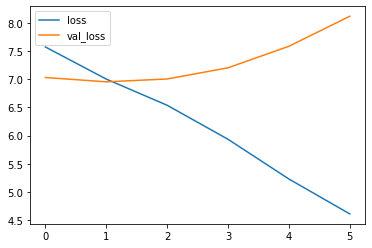

794/794 [==============================] - 670s 844ms/step - loss: 4.6088 - accuracy: 0.1791 - val_loss: 8.1200 - val_accuracy: 0.0455
Epoch 7/10
738/794 [==========================>...] - ETA: 47s - loss: 4.0883 - accuracy: 0.2314

In [ ]:
# trainning the model:
from tensorflow.keras.callbacks import ModelCheckpoint

# define checkpoints
checkpoint = ModelCheckpoint('/content/drive/MyDrive/chatBot_momtazi/model2-{epoch:03d}--{val_accuracy:03f}.h5',
                             verbose=1, monitor='val_loss',save_best_only=True,
                             save_weights_only=True, mode='min')

# complie the model
model.compile(loss= 'categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# train the model
model.fit(train_generator,batch_size = batch_s,
                    steps_per_epoch=(train_vec.shape[0]//batch_s),
          epochs=10, validation_data= val_tuple, 
          callbacks= [checkpoint, plot_losses])
# # Fit model using generator
# model.fit_generator(train_generator, 
#                     steps_per_epoch=len(test_vec.shape[0]//batch_s), 
#                     validation_data=validation_generator,
#                     nb_val_samples=len(validation_samples), nb_epoch=100)

**  **Note: Above training process left incompleted due to google colab run time limitation**  **

### Flush GPU
Occasionally we need to manually free up GPU!

In [ ]:
# # flush GPU
# # https://stackoverflow.com/questions/39758094/clearing-tensorflow-gpu-memory-after-model-execution
# !pip install numba 
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

## Making Predection

In [51]:
# Loading the model
best_model_path = '/content/drive/MyDrive/chatBot_momtazi/model2-002--0.072106.h5'
model.load_weights(best_model_path)

## Predicting one gaps

This part does not have any special logic.
 
It is just plug and play!

In [53]:
# making prediction
one_blank_sent_tokenized =  tokenizer.texts_to_sequences(one_blank_sent)
two_blank_sent_tokenized = tokenizer.texts_to_sequences(two_blank_sent)
one_blank_sent_tokenized = np.array([sent[-2:] for sent in one_blank_sent_tokenized])
one_blank_sent_tokenized

array([[405,   1],
       [ 42, 219],
       [109,   2],
       [ 34,  10]])

In [54]:
one_blank_pridicted = model.predict(one_blank_sent_tokenized)
one_blank_pridicted =np.argmax(one_blank_pridicted,axis=1)

In [55]:
one_blank_pridicted

array([ 5,  1, 10,  7])

In [56]:
tokensIDs_to_words(one_blank_pridicted,tokenizer.word_index)

['در', 'و', 'آن', 'را']

## Predicting two gaps

In [57]:
two_blank_sent_tokenized

[[12, 258, 382, 18, 49, 26, 35], [197, 5, 112, 1, 37, 133]]

In [58]:
two_blank_sent_tokenized = np.array([sent[-2:] for sent in two_blank_sent_tokenized])
two_blank_sent_tokenized

array([[ 26,  35],
       [ 37, 133]])

In [59]:
two_blank_pridicted = model.predict(two_blank_sent_tokenized)
two_blank_pridicted =np.argmax(two_blank_pridicted,axis=1)
two_blank_pridicted

array([7, 1])

In [60]:
tokensIDs_to_words(two_blank_pridicted,tokenizer.word_index)

['را', 'و']

In [65]:
second_gap = np.array([[35,7], [133,1]])
second_gap

array([[ 35,   7],
       [133,   1]])

In [66]:
second_gap_pridicted = model.predict(second_gap)
second_gap_pridicted =np.argmax(second_gap_pridicted,axis=1)
second_gap_pridicted

array([3, 1])

In [67]:
tokensIDs_to_words(second_gap_pridicted,tokenizer.word_index)

['به', 'و']

# Further Developments notes:
1. tokensIDs_to_words can be optimized by bi-directional dictionary
2. Write a general "sentence occurence probability calculator" function which receive smoothing name as an arg
3. If the sentence is too long, we might encounter "over/under flow" or "cancelation error" in "occurence_probablity" function. (use log function to prevent this)
4. I have used gived TEST SET for "development" (aka "evaluation") of model. Better to split train to "train" and "eval" and leave Test Set a side for final testing. Anyways, It was not the concern of this notebook. 
5. When I used the already commented generator for validation set, My model didn't get out of validation loss calculation. I Guess it was due to using infinite "while" loop. It seems that "steps_per_iteration" helps in not calling train set generator infinitly, but since we don't have such a variable for validaiton generation, our model calls validaiton generator utill it exaust, whihc in our case validation generator does not exaust (finish) at all. 
6. How to log training process and know exatcly what the hell is happening ? 


# Manage Resources

In [68]:
whos

Variable                         Type          Data/Info
--------------------------------------------------------
Dense                            type          <class 'keras.layers.core.dense.Dense'>
Embedding                        type          <class 'keras.layers.embeddings.Embedding'>
Flatten                          type          <class 'keras.layers.core.flatten.Flatten'>
PlotLosses                       type          <class '__main__.PlotLosses'>
Sequential                       type          <class 'keras.engine.sequential.Sequential'>
Tokenizer                        type          <class 'keras_preprocessing.text.Tokenizer'>
accum_3_gram_p_train             dict          n=56353
accum_3_gram_pr_test             dict          n=435
accum_3_gram_pr_train            dict          n=27832
accum_ngram                      function      <function accum_ngram at 0x7f7c0f809200>
batch_s                          int           1000
best_model_path                  str           /conte

# **Thanks for your time and attention. Please let me know my codes Weeknesses and ways to cover them**